In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

"\nfrom google.colab import drive\ndrive.mount('/content/drive/')\n"

In [ ]:

# Kompletan set za treniranje i labele
#!unzip '/content/drive/My Drive/LLAMAS/train_all_labels_small_ids.zip'
#!unzip '/content/drive/My Drive/LLAMAS/train_small_bil.zip'
# Smanjeni set za treniranje i labele
!unzip '/content/drive/My Drive/LLAMAS/train_labels_small_ids.zip'
!unzip '/content/drive/My Drive/LLAMAS/train_sort_small_bilinear.zip'
# Set za validiranje i labele
!unzip '/content/drive/My Drive/LLAMAS/valid_small_bilinear.zip'
!unzip '/content/drive/My Drive/LLAMAS/valid_labels_01.zip'
# Set za testiranje
!unzip '/content/drive/My Drive/LLAMAS/test_small_bilinear.zip'
!unzip '/content/drive/My Drive/LLAMAS/test_small_ids.zip'

"\n# Kompletan set za treniranje i labele\n#!unzip '/content/drive/My Drive/LLAMAS/train_all_labels_small_ids.zip'\n#!unzip '/content/drive/My Drive/LLAMAS/train_small_bil.zip'\n# Smanjeni set za treniranje i labele\n!unzip '/content/drive/My Drive/LLAMAS/train_labels_small_ids.zip'\n!unzip '/content/drive/My Drive/LLAMAS/train_sort_small_bilinear.zip'\n# Set za validiranje i labele\n!unzip '/content/drive/My Drive/LLAMAS/valid_small_bilinear.zip'\n!unzip '/content/drive/My Drive/LLAMAS/valid_labels_01.zip'\n# Set za testiranje\n!unzip '/content/drive/My Drive/LLAMAS/test_small_bilinear.zip'\n!unzip '/content/drive/My Drive/LLAMAS/test_small_ids.zip'\n"

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np
import math
import glob
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.model_zoo import load_url as loading
from torch.autograd import Variable
from sklearn import metrics

In [ ]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


In [ ]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [ ]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(
                                 replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, 
                               padding=3,bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.conv2 = nn.Conv2d(512, 2, kernel_size=1, stride=1, bias=False)
        self.upsample = nn.UpsamplingBilinear2d(size=(13, 40))
        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.upsample3 = nn.UpsamplingBilinear2d(size=(25, 80))
        self.upsample4 = nn.UpsamplingBilinear2d(size=(50, 160))
        self.conv3 = nn.Conv2d(256, 2, kernel_size=1, stride=1, bias=False)
        self.conv4 = nn.Conv2d(128, 2, kernel_size=1, stride=1, bias=False)
        self.conv5 = nn.Conv2d(64, 2, kernel_size=1, stride=1, bias=False)
        self.conv6 = nn.Conv2d(2, 2, kernel_size=3, stride=1, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        B, C, H, W = x.shape
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x0 = self.maxpool(x0) #f0 izlaz

        x1 = self.layer1(x0)  # f1 izlaz
        x2 = self.layer2(x1)  #f2 izlaz
        x3 = self.layer3(x2) # logiti na  predikciji /16 #f3 izlaz
        x4 = self.layer4(x3)  #f4 izlaz
        x5 = self.conv2(x4)

        x9 = torch.nn.functional.interpolate(x5, size=(H,W), mode='bilinear')
        
        x5 = self.upsample(x5)
        x3 = self.conv3(x3)
        x5 += x3
        x5 = self.conv6(x5)
        x6 = torch.nn.functional.interpolate(x5, size=(H,W), mode='bilinear')
        
        x5 = self.upsample3(x5)
        x2 = self.conv4(x2)
        x5 += x2
        x5 = self.conv6(x5)
        x7 = torch.nn.functional.interpolate(x5, size=(H,W), mode='bilinear')

        x5 = self.upsample4(x5)
        x1 = self.conv5(x1)
        x5 += x1
        x5 = self.conv6(x5)
        x8 = torch.nn.functional.interpolate(x5, size=(H,W), mode='bilinear')
        
        return x9, x6, x7, x8

    def forward(self, x):
        return self._forward_impl(x)

In [ ]:
def _load_pretrained(model, url, inchans=3):
    state_dict = loading(url)
    if inchans == 1:
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
    elif inchans != 3:
        assert False, "Invalid number of inchans for pretrained weights"
    model.load_state_dict(state_dict, strict=False)

def resnet18(pretrained=False, inchans=3):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    if pretrained:
        _load_pretrained(model, model_urls['resnet18'], inchans=inchans)
    return model

In [ ]:
class LlamasDataset(Dataset):
    """LLAMAS dataset for lane tracking."""
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    def __init__(self,im_root, label_root):
        self.images = list(sorted(glob.glob(im_root+'*.png')))
        self.im_root = im_root
        self.labels = list(sorted(glob.glob(label_root+'*.png')))
        self.label_root = label_root
        self.normalize = transforms.Normalize([0.5],[0.5])
        self.tenzoriraj = transforms.ToTensor()
        self.area = (0, 159, 638, 359)
    def transforms(self, image, label=None):
          image = image.crop(self.area)
          image = self.tenzoriraj(image)
          image = self.normalize(image)

          label = label.crop(self.area)
          label = np.array(label)
          label = torch.tensor(label)

          return image, label
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        image = Image.open(self.images[item])
        label= Image.open(self.labels[item])
        return self.transforms(image, label)

In [ ]:
train_root = 'train_sort_small_bilinear/'
label_root = 'train_labels_small_ids/'

test_root = 'test_small_bilinear/'
test_labels_root = 'test_small_ids/'

valid_root = 'valid_small/'
valid_labels_root = 'valid_labels_01/'

device = torch.device('cuda')
epochs = 80
batch_size = 12

In [ ]:
dataset_train = LlamasDataset(im_root=train_root, label_root=label_root)
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)

dataset_test = LlamasDataset(im_root=test_root, label_root=test_labels_root)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, num_workers=2)

dataset_valid = LlamasDataset(im_root=valid_root, label_root=valid_labels_root)
valid_loader = DataLoader(dataset=dataset_valid, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
network = resnet18(pretrained=True, inchans=1)
weights = torch.tensor([0.4, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(network.parameters())
network.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def train(epoch):
    network.train()
    correct = 0
    iou = 0
    correct1 = 0
    iou1 = 0
    correct2 = 0
    iou2 = 0
    correct0 =0
    iou0 = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = target.squeeze(1)
        target = target.type(torch.cuda.LongTensor)
       
        optimizer.zero_grad()
        o0, o1, o2, output= network(data)
        loss = criterion(output, target)
        loss += 0.125*criterion(o0, target)
        loss += 0.25*criterion(o1, target)
        loss += 0.5*criterion(o2, target)
        loss.backward()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]
        f, i = metrics(pred.reshape(-1), target.reshape(-1))
        iou += i
        correct += f

        pred = o1.data.max(1, keepdim=True)[1]
        f, i = metrics(pred.reshape(-1), target.reshape(-1))
        iou1 += i
        correct1 += f


        pred = o2.data.max(1, keepdim=True)[1]
        f, i = metrics(pred.reshape(-1), target.reshape(-1))
        iou2 += i
        correct2 += f

        pred = o0.data.max(1, keepdim=True)[1]
        f, i = metrics(pred.reshape(-1), target.reshape(-1))
        iou0 += i
        correct0 += f

    print('Train   | Epoch {} | Loss: {:.4f}| Accuracy: {:.4}%| IoU: {:.4f}%'.format(
          epoch, loss.item(), 100.*correct/(batch_idx +1), 100.*iou/(batch_idx+1)))
    print('\t| 2 sloja | Accuracy: {:.4f}%| IoU: {:.4f}%'.format(
          100.*correct2/(batch_idx +1), 100.*iou2/(batch_idx+1)))    
    print('\t| 1 sloj  | Accuracy: {:.4f}%| IoU: {:.4f}%'.format(
          100.*correct1/(batch_idx +1), 100.*iou1/(batch_idx+1)))
    print('\t| baseline| Accuracy: {:.4f}%| IoU: {:.4f}%'.format(
          100.*correct0/(batch_idx +1), 100.*iou0/(batch_idx+1)))
              

In [ ]:
def valid(epoch):
    network.eval()
    valid_loss = 0
    correct = 0
    iou = 0
    correct1 = 0
    iou1 = 0
    correct2 = 0
    iou2 = 0
    valid_loss1 = 0
    valid_loss2 = 0
    correct0 = 0
    iou0 = 0
    valid_loss0 = 0
    total_valid = len(valid_loader.dataset) / 12
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze(1)
            target = target.type(torch.cuda.LongTensor)

            o0, o1, o2, output = network(data)

            valid_loss += criterion(output, target).item()
            valid_loss0 += criterion(o0, target).item()
            valid_loss1 += criterion(o1, target).item()
            valid_loss2 += criterion(o2, target).item()
            
            pred = output.data.max(1, keepdim=True)[1]
            f, i = metrics(pred.reshape(-1), target.reshape(-1))
            iou += i
            correct += f

            pred = o1.data.max(1, keepdim=True)[1]
            f, i = metrics(pred.reshape(-1), target.reshape(-1))
            iou1 += i
            correct1 += f


            pred = o2.data.max(1, keepdim=True)[1]
            f, i = metrics(pred.reshape(-1), target.reshape(-1))
            iou2 += i
            correct2 += f

            pred = o0.data.max(1, keepdim=True)[1]
            f, i = metrics(pred.reshape(-1), target.reshape(-1))
            iou0 += i
            correct0 += f
            
    valid_loss /= total_valid
    iou /= total_valid
    correct /= total_valid
    
    valid_loss1 /= total_valid
    iou1 /= total_valid
    correct1 /= total_valid
    
    valid_loss2 /= total_valid
    iou2 /= total_valid
    correct2 /= total_valid

    valid_loss0 /= total_valid
    iou0 /= total_valid
    correct0 /= total_valid

    print('Valid| Final| Avg. loss: {:.4f}| Accuracy: {:.4f}%| IoU: {:.4f}%'.format(
    valid_loss, 100.*correct, 100.*iou))
    print('Valid| Predikcije na /16| Avg. loss: {:.4f}| Accuracy: {:.4f}%| IoU: {:.4f})'.format(
    valid_loss1, 100.*correct1, 100.*iou1))
    print('Valid| Predikcije na /8| Avg. loss: {:.4f}| Accuracy: {:.4f}%| IoU: {:.4f}%'.format(
    valid_loss2, 100.*correct2, 100.*iou2))
    print('Valid| Osnovni model| Avg. loss: {:.4f}| Accuracy: {:.4f}%| IoU: {:.4f}%'.format(
    valid_loss0, 100.*correct0, 100.*iou0))

In [ ]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    iou = 0
    correct1 = 0
    iou1 = 0
    correct2 = 0
    iou2 = 0
    test_loss1 = 0
    test_loss2 = 0
    correct0 = 0
    iou0 = 0
    test_loss0 = 0
    total_test = len(test_loader.dataset) / 12
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze(1)
            target = target.type(torch.cuda.LongTensor)

            o0, o1, o2, output = network(data)

            test_loss += criterion(output, target).item()
            test_loss0 += criterion(o0, target).item()
            test_loss1 += criterion(o1, target).item()
            test_loss2 += criterion(o2, target).item()
            
            pred = output.data.max(1, keepdim=True)[1]
            f, i = metrics(pred.reshape(-1), target.reshape(-1))
            iou += i
            correct += f

            pred = o1.data.max(1, keepdim=True)[1]
            f, i = metrics(pred.reshape(-1), target.reshape(-1))
            iou1 += i
            correct1 += f


            pred = o2.data.max(1, keepdim=True)[1]
            f, i = metrics(pred.reshape(-1), target.reshape(-1))
            iou2 += i
            correct2 += f

            pred = o0.data.max(1, keepdim=True)[1]
            f, i = metrics(pred.reshape(-1), target.reshape(-1))
            iou0 += i
            correct0 += f
            
    test_loss /= total_test
    iou /= total_test
    correct /= total_test
    
    test_loss1 /= total_test
    iou1 /= total_test
    correct1 /= total_test
    
    test_loss2 /= total_test
    iou2 /= total_test
    correct2 /= total_test

    test_loss0 /= total_test
    iou0 /= total_test
    correct0 /= total_test

    print('Test | Final| Avg. loss: {:.4f}| Accuracy: {:.4f}%| IoU: {:.4f}%'.format(
    test_loss, 100.*correct, 100.*iou))
    print('Test | Predikcije na /16| Avg. loss: {:.4f}| Accuracy: {:.4f}%| IoU: {:.4f})'.format(
    test_loss1, 100.*correct1, 100.*iou1))
    print('Test | Predikcije na /8| Avg. loss: {:.4f}| Accuracy: {:.4f}%| IoU: {:.4f}%'.format(
    test_loss2, 100.*correct2, 100.*iou2))
    print('Test | Osnovni model| Avg. loss: {:.4f}| Accuracy: {:.4f}%| IoU: {:.4f}%'.format(
    test_loss0, 100.*correct0, 100.*iou0))

In [ ]:
def metrics(y_true, y_pred):
    """
    Metoda koja implementira računanje potrebnih mjera za evaluaciju modela.
    tp - true poositive
    tf - true negative
    fp - false positive
    fn - false negative
    precision - preciznost
    recall - odziv
    f1 - mjera točnosti za nebalansirane klase
    iou - Jaccardov index, mjera sličnosti modela
    """
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1 = 2* (precision*recall) / (precision + recall)
    iou = tp / (tp + fp + fn)
    
    return f1, iou

In [ ]:
for epoch in range(1, epochs + 1):
    time0 = time.time()
    train(epoch)
    print("Time: {:.4f} s".format(time.time() - time0))
    valid(epoch)
    print()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Train   | Epoch 1 | Loss: 0.1633| Accuracy: 48.57%| IoU: 32.6350%
	| 2 sloja | Accuracy: 41.1059%| IoU: 26.4468%
	| 1 sloj  | Accuracy: 30.5421%| IoU: 18.3547%
	| baseline| Accuracy: nan%| IoU: 9.5947%
Time: 56.9875 s
Valid| Final| Avg. loss: 0.0908| Accuracy: 58.1504%| IoU: 41.0372%
Valid| Predikcije na /16| Avg. loss: 0.1083| Accuracy: 43.7989%| IoU: 28.0755)
Valid| Predikcije na /8| Avg. loss: 0.0943| Accuracy: 53.3945%| IoU: 36.4607%
Valid| Osnovni model| Avg. loss: 0.1206| Accuracy: 32.7192%| IoU: 19.5855%

Train   | Epoch 2 | Loss: 0.1242| Accuracy: 58.53%| IoU: 41.4197%
	| 2 sloja | Accuracy: 53.1367%| IoU: 36.2416%
	| 1 sloj  | Accuracy: 39.3935%| IoU: 24.6312%
	| baseline| Accuracy: 25.1756%| IoU: 14.6129%
Time: 57.0314 s
Valid| Final| Avg. loss: 0.0813| Accuracy: 60.8915%| IoU: 43.8152%
Valid| Predikcije na /16| Avg. loss: 0.0999| Accuracy: 42.2192%| IoU: 26.8029)
Valid| Predikcije na /8| Avg. loss: 0.0848| Accuracy: 56.3508%| IoU: 39.2751%
Valid| Osnovni model| Avg. loss: 0.

In [ ]:
test()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Test | Final| Avg. loss: 0.0981| Accuracy: 50.0655%| IoU: 33.5301%
Test | Predikcije na /16| Avg. loss: 0.1105| Accuracy: 36.9408%| IoU: 22.7530)
Test | Predikcije na /8| Avg. loss: 0.1052| Accuracy: 46.6864%| IoU: 30.5618%
Test | Osnovni model| Avg. loss: 0.1132| Accuracy: 28.0664%| IoU: 16.3819%


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


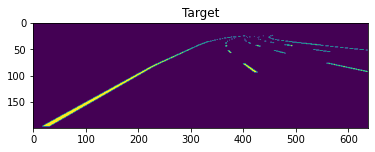

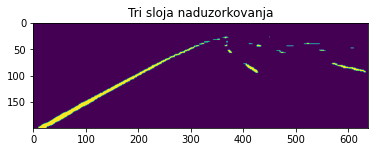

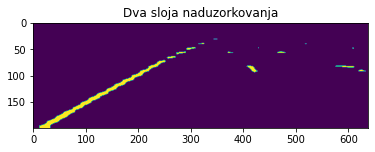

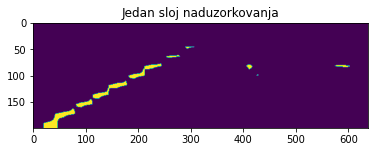

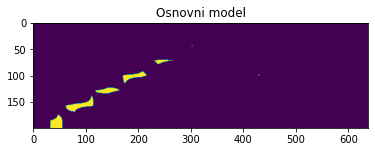

In [ ]:
valid_loader2 = DataLoader(dataset=dataset_train, batch_size=1, shuffle=True, num_workers=2)

dataiter = iter(valid_loader2)
sljed = dataiter.next()
slika, tar = sljed
correct= 0
with torch.no_grad():
          data, target = slika.to(device), tar.to(device)
          target = tar.squeeze(1)
          target = target.type(torch.cuda.LongTensor)
          o0, o1, o2, output = network(data)
          pred = output.data.max(1, keepdim=True)[1]
          pred1 = o1.data.max(1, keepdim=True)[1]
          pred2 = o2.data.max(1, keepdim=True)[1]
          pred3 = o0.data.max(1, keepdim=True)[1]


  
izlaz = pred.squeeze(0)
izlaz = izlaz.squeeze(0)
izlaz = izlaz.cpu()
izlaz = izlaz.numpy()
izlaz = izlaz.astype(np.uint8)

izlaz1 = pred1.squeeze(0)
izlaz1 = izlaz1.squeeze(0)
izlaz1 = izlaz1.cpu()
izlaz1 = izlaz1.numpy()
izlaz1 = izlaz1.astype(np.uint8)

izlaz2 = pred2.squeeze(0)
izlaz2 = izlaz2.squeeze(0)
izlaz2 = izlaz2.cpu()
izlaz2 = izlaz2.numpy()
izlaz2 = izlaz2.astype(np.uint8)

izlaz3 = pred3.squeeze(0)
izlaz3 = izlaz3.squeeze(0)
izlaz3 = izlaz3.cpu()
izlaz3 = izlaz3.numpy()
izlaz3 = izlaz3.astype(np.uint8)

tar = target.squeeze(0)
tar = tar.cpu()
tar = tar.numpy()
tar = tar.astype(np.uint8)


plt.figure()
plt.imshow(tar)
plt.title('Target')
plt.show()

plt.figure()
plt.imshow(izlaz)
plt.title('Tri sloja naduzorkovanja')
plt.show()

plt.figure()
plt.imshow(izlaz2)
plt.title('Dva sloja naduzorkovanja')
plt.show()

plt.figure()
plt.imshow(izlaz1)
plt.title('Jedan sloj naduzorkovanja')
plt.show()

plt.figure()
plt.imshow(izlaz3)
plt.title('Osnovni model')
plt.show()


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


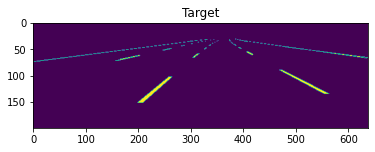

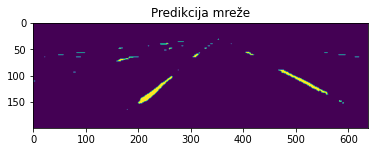

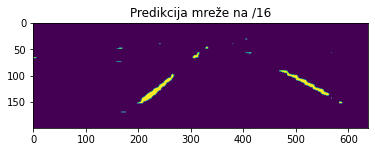

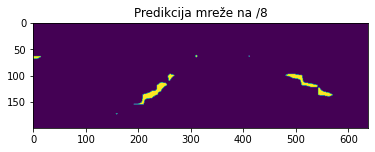

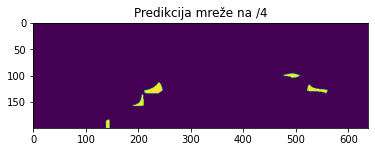

In [ ]:
valid_loader2 = DataLoader(dataset=dataset_test, batch_size=1, shuffle=True, num_workers=2)

dataiter = iter(valid_loader2)
sljed = dataiter.next()
slika, tar = sljed
correct= 0
with torch.no_grad():
          data, target = slika.to(device), tar.to(device)
          target = tar.squeeze(1)
          target = target.type(torch.cuda.LongTensor)
          o0, o1, o2, output = network(data)
          pred = output.data.max(1, keepdim=True)[1]
          pred1 = o1.data.max(1, keepdim=True)[1]
          pred2 = o2.data.max(1, keepdim=True)[1]
          pred3 = o0.data.max(1, keepdim=True)[1]


  
izlaz = pred.squeeze(0)
izlaz = izlaz.squeeze(0)
izlaz = izlaz.cpu()
izlaz = izlaz.numpy()
izlaz = izlaz.astype(np.uint8)

izlaz1 = pred1.squeeze(0)
izlaz1 = izlaz1.squeeze(0)
izlaz1 = izlaz1.cpu()
izlaz1 = izlaz1.numpy()
izlaz1 = izlaz1.astype(np.uint8)

izlaz2 = pred2.squeeze(0)
izlaz2 = izlaz2.squeeze(0)
izlaz2 = izlaz2.cpu()
izlaz2 = izlaz2.numpy()
izlaz2 = izlaz2.astype(np.uint8)

izlaz3 = pred3.squeeze(0)
izlaz3 = izlaz3.squeeze(0)
izlaz3 = izlaz3.cpu()
izlaz3 = izlaz3.numpy()
izlaz3 = izlaz3.astype(np.uint8)

tar = target.squeeze(0)
tar = tar.cpu()
tar = tar.numpy()
tar = tar.astype(np.uint8)


plt.figure()
plt.imshow(tar)
plt.title('Target')
plt.show()

plt.figure()
plt.imshow(izlaz)
plt.title('Predikcija mreže')
plt.show()

plt.figure()
plt.imshow(izlaz2)
plt.title('Predikcija mreže na /16')
plt.show()

plt.figure()
plt.imshow(izlaz1)
plt.title('Predikcija mreže na /8')
plt.show()

plt.figure()
plt.imshow(izlaz3)
plt.title('Predikcija mreže na /4')
plt.show()
